# <span style = "color : black"> **Import & Data Load**

In [1]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms,datasets
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal

bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [2]:
sig = torch.nn.Sigmoid()

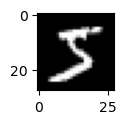

In [3]:
plt.figure(figsize=(2,1))
plt.imshow(train_dataset[0][0].permute(1,2,0).numpy(),cmap="gray")

# <span style = "color : black"> **Modeling**

In [4]:
class Encoder(nn.Module):
    def __init__(self,x_dim,latent_dim): #latent space의 dimension은 output_dim // 2
        super().__init__()
        self.output_dim = latent_dim * 2 #hidden layer output dimension (= latent space dim * 2)
        self.latent_dim = latent_dim     #latent variable dimension (= last hidden dim // 2)
        
        self.l1 = torch.nn.Linear(x_dim,x_dim // 2)
        self.tanh = torch.nn.Tanh()
        self.l2 = torch.nn.Linear(x_dim // 2,self.output_dim)
        #relu
        
    def forward(self,x):
        out = self.tanh(self.l1(x)) #l1 out
        out = self.tanh(self.l2(out)) #l2 out
        #Note : Dnn's output are mean,log variance
        #half of last hidden layers output => mean
        #half of last else hidden layers output => log variance        
        mean = out[:,:self.latent_dim]    #mean
        log_var = out[:,self.latent_dim:] #log_variance
        return mean,log_var

In [5]:
class Z_Sampler(nn.Module):
    def __init__(self,latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
    def forward(self,mean,log_var):
        """
        Sampling z with reparameterization trick
        """
        eps_sampler = MultivariateNormal(loc = torch.tensor([0]*(self.latent_dim)).float(),covariance_matrix = torch.eye(self.latent_dim))
        eps_realizations = eps_sampler.sample()
        #reparameterization trick z = mu + std * epsilon
        #std = exp(ln(1/2 * variance))
        z = mean + torch.exp(0.5 * log_var) * eps_realizations  
        return z

In [6]:
class Decoder(nn.Module):
    def __init__(self,latent_dim,out_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.out_dim = out_dim 
        
        self.l3 = torch.nn.Linear(latent_dim,latent_dim * 2)
        self.tanh = torch.nn.Tanh()
        self.l4 = torch.nn.Linear(latent_dim * 2,out_dim)
        #softmax + cross entropy loss
    def forward(self,z):
        out = self.tanh(self.l3(z))
        out = self.l4(out)
        return out

In [7]:
class VAE(nn.Module):
    def __init__(self,x_dim,latent_dim): #decoder추가해야함
        super().__init__()
        self.x_dim = self.out_dim = x_dim
        self.latent_dim = latent_dim
        
        self.encoder = Encoder(x_dim,latent_dim)
        self.z_sampler = Z_Sampler(latent_dim)
        self.decoder = Decoder(latent_dim,x_dim)
    def forward(self,x):
        mean_1,log_var_1 = self.encoder(x) # input : x // output : parameter phi of q(z|x;\phi)
        z = self.z_sampler(mean_1,log_var_1) # input : parameter phi // output : realization of z
        xhat=self.decoder(z)
        return xhat

torch.Size([1, 784])


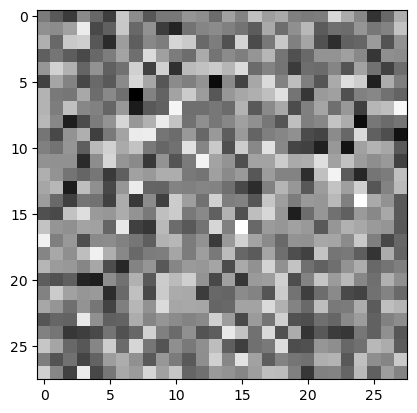

In [8]:
_tmp = train_dataset[0][0].reshape(-1,28*28)
vae = VAE(x_dim = 28 * 28,latent_dim = 10)
print(vae(_tmp).shape)
plt.imshow(sig(vae(_tmp)).reshape(28,28).data,cmap = "gray")